# Dissecting Transformers

The first step for us is to run `python3 data/nlab/prepare.py` after having cloned the `nlab-content` submodule. This will create a file `data/nlab/input.md` of roughly 91 MiB.

In [56]:
with open("../data/nlab/input.md", "r", encoding="utf-8") as fd:
    text = fd.read()

print(len(text))

95159406


In [57]:
vocab = list(sorted(list(set(text))))
vocab_size = len(vocab)
print("".join(vocab))
print(vocab_size)

	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~ §¨«­¯°²³´µ·¹»ÀÁÄÅÆÉÎÓÖ×ØÜßàáâãäåæçèéêëìíîïñòóôöøùúûüýĀāăąĆćĈČčđĕęěğīĭİıķŁłńōőŒœŗřŚśŝŞşŠšţťūűŻżŽžſșțȩɐɪʰʲʹʼˆˈ̧̣̀́̂̃̄̈̌͡ΑΒΓΔΕΘΛΜΠΣΦΨΩάέήίαβγδεζηθικλμνξοπρςστυφχψωόύϑϒϕϖϵАБВГДЕЖЗИКЛМНОПРСТУФХШЭЮЯабвгдежзийклмнопрстуфхцчшщъыьэюяёіћᵒᵖᵢᶜṣṬỳἀἐἓἕἢἣἰὁὄὅὐὑὗὰὲὴὶὸῃῆῇῖῦῶῷ ​‌‍‎‐‑–—‘’“”„†•…  ′⁻ⁿ₀₁₂₄₆₇₈₉ℂℋℓ№ℚℤΩℵ⅋Ⅱ←→↦⇓⇔⇸∀∂∈−∗√∞∧∼≅≈≠≡≤≥≺⊂⊗⋮─◦♧♭✄【】のオダネノブヨ下五何信分夫学山幾式引形微德徹志数方李村田程空米系經经群蕉论谷豊辻道郎间香ﬀﬁﬂﬃ
479


In [58]:
# import tiktoken

# enc = tiktoken.get_encoding("gpt2")
# enc.n_vocab
# t = enc.encode(text[:50])
# print(t)
# print(enc.decode(t))
ctoi = {ch: i for i, ch in enumerate(vocab)}
itoc = {i: ch for i, ch in enumerate(vocab)}

encode = lambda s: [ctoi[c] for c in s]
decode = lambda v: "".join([itoc[i] for i in v])

print(encode(text[:50]))

[1, 13, 15, 15, 2, 93, 28, 2, 16, 84, 75, 73, 74, 86, 42, 67, 80, 70, 53, 75, 70, 71, 95, 1, 13, 15, 15, 2, 93, 28, 2, 16, 86, 81, 69, 2, 16, 69, 78, 75, 69, 77, 38, 81, 89, 80, 2, 86, 67, 68]


In [59]:
import torch

data = torch.tensor(encode(text), dtype=torch.long, device="cuda")
print(data.shape, data.dtype)
print(data[:1000])

torch.Size([95159406]) torch.int64
tensor([ 1, 13, 15, 15,  2, 93, 28,  2, 16, 84, 75, 73, 74, 86, 42, 67, 80, 70,
        53, 75, 70, 71, 95,  1, 13, 15, 15,  2, 93, 28,  2, 16, 86, 81, 69,  2,
        16, 69, 78, 75, 69, 77, 38, 81, 89, 80,  2, 86, 67, 68, 75, 80, 70, 71,
        90, 31,  4, 18,  4, 95,  1,  5,  5,  5,  2, 37, 81, 80, 86, 71, 90, 86,
         1,  5,  5,  5,  5,  2, 50, 74, 75, 78, 81, 85, 81, 82, 74, 91,  1, 13,
        15, 15,  2, 93, 28,  2, 16, 74, 75, 70, 71, 95,  1, 61, 61,  3, 75, 80,
        69, 78, 87, 70, 71,  2, 82, 74, 75, 78, 81, 85, 81, 82, 74, 91,  2, 15,
         2, 69, 81, 80, 86, 71, 80, 86, 85, 63, 63,  1, 31, 15, 15,  1, 31, 15,
        15,  1, 31, 15, 15,  1,  1,  5, 37, 81, 80, 86, 71, 80, 86, 85,  5,  1,
        12,  2, 86, 67, 68, 78, 71,  2, 81, 72,  2, 69, 81, 80, 86, 71, 80, 86,
        85,  1, 93, 28, 86, 81, 69, 95,  1,  1,  5,  5,  2, 43, 70, 71, 67,  1,
         1, 10, 16, 16, 16, 11,  1,  1, 35,  2, 82, 81, 75, 80, 86,  2, 81, 72,
     

In [60]:
n = int(0.9 * data.shape[0])
train_data = data[:n]
val_data = data[n:]
print(train_data.shape, val_data.shape)

torch.Size([85643465]) torch.Size([9515941])


In [61]:
context_length = 8
train_data[: context_length + 1]

tensor([ 1, 13, 15, 15,  2, 93, 28,  2, 16], device='cuda:0')

In [62]:
x = train_data[:context_length]
y = train_data[1 : context_length + 1]
for t in range(context_length):
    context = x[: t + 1]
    target = y[t]
    print(f"When input is {context} the target: {target}")

When input is tensor([1], device='cuda:0') the target: 13
When input is tensor([ 1, 13], device='cuda:0') the target: 15
When input is tensor([ 1, 13, 15], device='cuda:0') the target: 15
When input is tensor([ 1, 13, 15, 15], device='cuda:0') the target: 2
When input is tensor([ 1, 13, 15, 15,  2], device='cuda:0') the target: 93
When input is tensor([ 1, 13, 15, 15,  2, 93], device='cuda:0') the target: 28
When input is tensor([ 1, 13, 15, 15,  2, 93, 28], device='cuda:0') the target: 2
When input is tensor([ 1, 13, 15, 15,  2, 93, 28,  2], device='cuda:0') the target: 16


In [63]:
torch.manual_seed(303)

batch_size = 4
context_length = 8


def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - context_length, (batch_size,))
    x = torch.stack([data[i : i + context_length] for i in ix])
    y = torch.stack([data[i + 1 : i + 1 + context_length] for i in ix])
    x, y = x.to("cuda"), y.to("cuda")
    return x, y


xb, yb = get_batch("train")
print("inputs:")
print(xb.shape)
# print(xb)
print("targets:")
print(yb.shape)
# print(yb)

print("---")

# for b in range(batch_size):
#     for t in range(context_length):
#         context = xb[b, :t+1]
#         target = yb[b, t]
#         print(f"When input is {context} the target: {target}")

inputs:
torch.Size([4, 8])
targets:
torch.Size([4, 8])
---


In [64]:

print("---")

# for b in range(batch_size):
#     for t in range(context_length):
#         context = xb[b, :t+1]
#         target = yb[b, t]
#         print(f"When input is {context} the target: {target}")

---


In [65]:
import torch
import torch.nn as nn
from torch.nn import functional as F

torch.manual_seed(303)

class BigramLM(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size, device="cuda")

    def forward(self, idx, targets=None):
        logits = self.token_embedding_table(idx)
        B, T , C = logits.shape
        if targets is None:
            loss = None
        else:
            l = logits.view(B * T, C)
            l = l.to("cuda")
            targets = targets.view(B * T)
            targets = targets.to("cuda")
            loss = F.cross_entropy(l, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

m = BigramLM(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape, loss)

print(-torch.log(torch.tensor([1/479])))

torch.Size([4, 8, 479]) tensor(6.8937, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor([6.1717], device='cuda:0')


In [66]:
decode(m.generate(torch.zeros((1, 1), dtype=torch.long, device="cuda"), max_new_tokens=100)[0].tolist())

'\tàè←Ωὑœ8ïæ豊Àżヨˆνʹœ方ı³éỳ¹ßù\u2028₀‐&А【̌lò李őв−̀Æ─уVł»д系ÄI✄ù♧ићłiOἐ⁻\u200c♧ЗTНêыяΩ幾НŠÅ·Aé^äű五\u200d五∼cŒïī§№ёâr≅)%∗²Zcγέ'

In [67]:
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-4)

In [68]:
batch_size = 32
for steps in range(1000):
    xb, yb = get_batch("train")

    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

torch.save(m.state_dict(), "model.bin")

6.493341445922852


In [69]:
decode(m.generate(torch.zeros((1, 1), dtype=torch.long, device="cuda"), max_new_tokens=100)[0].tolist())

'\tXц山ęΠµń∈̣ℓё√引₂όΜ√蕉иϑʹῖΩ0$Żâōϑëâ%DцÖϵ李⇓Ĉ\u2028эΑῶ·‑«ηἣ群间еAwᵒșb1ñД»\u200c志ρPὗ9⊗道3L↦úSἰòℋßſœ₂Yˈû\u200bσφб)тГč$бlB≺šµ@ὶ'

### The mathematical trick in self-attention

In [70]:
torch.manual_seed(303)
B, T, C = 4, 8, 2
x = torch.randn(B, T, C)
x.shape
x = x.to("cuda")

In [71]:
xbow = torch.zeros((B, T, C), device="cuda")
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1]
        xbow[b, t] = torch.mean(xprev, 0)

In [72]:
x[0]

tensor([[-1.1819,  0.9192],
        [ 1.6877, -0.7448],
        [-0.3231,  1.6951],
        [-0.8043,  1.3372],
        [-0.0165, -0.0025],
        [ 2.0389, -0.2513],
        [-0.5734, -0.7433],
        [ 0.1496,  0.5902]], device='cuda:0')

In [73]:
xbow[0]

tensor([[-1.1819,  0.9192],
        [ 0.2529,  0.0872],
        [ 0.0609,  0.6232],
        [-0.1554,  0.8017],
        [-0.1276,  0.6409],
        [ 0.2335,  0.4922],
        [ 0.1182,  0.3157],
        [ 0.1221,  0.3500]], device='cuda:0')

In [74]:
torch.manual_seed(303)

a = torch.tril(torch.ones(3, 3, device="cuda"))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0, 10, (3, 2), device="cuda").float()
c = a @ b

print(a)
print(b)
print(c)

tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([[4., 8.],
        [1., 9.],
        [3., 4.]], device='cuda:0')
tensor([[4.0000, 8.0000],
        [2.5000, 8.5000],
        [2.6667, 7.0000]], device='cuda:0')


In [75]:
wei = torch.tril(torch.ones(T, T, device="cuda"))
wei = wei / wei.sum(1, keepdim=True)
xbow2 = wei @ x
print(xbow[0])
print(xbow2[0])

tensor([[-1.1819,  0.9192],
        [ 0.2529,  0.0872],
        [ 0.0609,  0.6232],
        [-0.1554,  0.8017],
        [-0.1276,  0.6409],
        [ 0.2335,  0.4922],
        [ 0.1182,  0.3157],
        [ 0.1221,  0.3500]], device='cuda:0')
tensor([[-1.1819,  0.9192],
        [ 0.2529,  0.0872],
        [ 0.0609,  0.6232],
        [-0.1554,  0.8017],
        [-0.1276,  0.6409],
        [ 0.2335,  0.4922],
        [ 0.1182,  0.3157],
        [ 0.1221,  0.3500]], device='cuda:0')


In [76]:
torch.set_default_device("cuda")

In [77]:
tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3)

True

In [78]:
n_embed = 32


class NewLM(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx) # (B, T, C)
        pos_emb = self.position_embedding_table(torch.arange(T, device="cuda"))
        x = tok_emb + pos_emb
        logits = self.lm_head(x) # (B, T, vocab_size)

        if targets is None:
            loss = None
        else:

            B, T , C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            logits, loss = self(idx)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [79]:
model = NewLM()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

In [80]:
batch_size = 32
for steps in range(1000):
    xb, yb = get_batch("train")

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

3.022827625274658


In [81]:
torch.manual_seed(303)

B, T, C = 4, 8, 32
x = torch.randn(B, T, C)


head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

k = key(x) # (B, T, 16)
q = query(x) # (B, T, 16)

wei = q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) -> (B, T, T)

tril - torch.tril(torch.ones(T, T))
# wei = torch.zeros((T, T))
wei = wei.masked_fill(tril == 0, float("-inf"))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v

out

tensor([[[ 7.6557e-01,  7.6792e-02, -3.5116e-02, -1.7187e-01, -4.2298e-01,
          -1.0044e+00,  2.1866e-01, -2.1635e-02, -4.3660e-01, -1.6724e-01,
          -3.1453e-01, -5.1809e-02,  1.2839e-01,  5.0777e-02,  4.5718e-01,
          -2.6916e-02],
         [ 3.2715e-01, -4.8458e-01,  1.3244e-01, -1.4200e-01, -3.5120e-01,
           1.3434e-02, -3.2762e-02,  9.7101e-02,  9.1106e-01, -1.9292e-01,
          -2.6209e-01,  5.2649e-01, -3.6265e-01,  5.4872e-01,  2.3383e-01,
          -4.8467e-01],
         [ 2.5620e-01, -2.7523e-01,  2.2497e-01, -3.7015e-02, -3.0671e-01,
          -8.5953e-02,  1.6372e-01,  8.8102e-02,  7.4853e-01, -1.3400e-01,
          -2.2559e-01,  3.7459e-01, -1.2368e-01,  2.9392e-01,  1.9261e-01,
          -3.8742e-01],
         [-4.8532e-01,  6.3573e-01,  8.9195e-01,  6.2057e-01, -4.6279e-04,
           9.8741e-03,  1.2114e+00,  1.1948e-01,  6.5533e-01,  2.4530e-01,
           1.6259e-02, -1.7245e-01,  1.0460e+00, -9.2361e-01, -2.0221e-01,
          -1.1559e-01],
    

Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating

In [82]:
import torchinfo

torchinfo.summary(model, input_size=(batch_size, context_length), dtypes=[torch.long])

Layer (type:depth-idx)                   Output Shape              Param #
NewLM                                    [32, 8, 479]              --
├─Embedding: 1-1                         [32, 8, 32]               15,328
├─Embedding: 1-2                         [8, 32]                   256
├─Linear: 1-3                            [32, 8, 479]              15,807
Total params: 31,391
Trainable params: 31,391
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.00
Input size (MB): 0.00
Forward/backward pass size (MB): 1.05
Params size (MB): 0.13
Estimated Total Size (MB): 1.18

In [83]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("runs/experiment_1")
writer.add_graph(model, (xb, yb))
writer.close()

In [84]:
k = torch.randn(B, T, head_size)
q = torch.randn(B, T, head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5
print(k.var(), q.var(), wei.var())

tensor(1.0308, device='cuda:0') tensor(0.9483, device='cuda:0') tensor(0.9065, device='cuda:0')


In [85]:
F.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872], device='cuda:0')

In [86]:
F.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*80, dim=-1)

tensor([1.2664e-14, 4.7809e-25, 1.1254e-07, 4.7809e-25, 1.0000e+00],
       device='cuda:0')

In [87]:
batch_size = 64
context_length = 256
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = 200
n_embed = 384
head_size = n_embed
n_layer = 6
n_head = 6
dropout = 0.2

In [88]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()

        self.head_size = head_size

        self.c_attn = nn.Linear(n_embed, 3 * head_size, bias=False)
        # self.key = nn.Linear(n_embed, head_size, bias=False)
        # ...
        self.register_buffer("tril", torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape

        k, q, v = self.c_attn(x).split(self.head_size, dim=-1)

        wei = q @ k.transpose(-2, -1) * C**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float("-inf"))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        return wei @ v

In [89]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embed, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.dropout(self.proj(torch.cat([h(x) for h in self.heads], dim=-1)))

In [90]:
class FeedForward(nn.Module):
    def __init__(self, n_embed):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed),
            nn.GELU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

In [91]:
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

In [92]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(context_length, n_embed)
        self.blocks = nn.Sequential(
            *[Block(n_embed, n_head=n_head) for _ in range(n_layer)],
            nn.LayerNorm(n_embed),
        )
        self.lm_head = nn.Linear(n_embed, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device="cuda"))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B * T, C)
            targets = targets.view(B * T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -context_length:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx

In [96]:
torch.manual_seed(303)

model = Decoder()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [97]:
torchinfo.summary(model, input_size=(batch_size, context_length), dtypes=[torch.long])

Layer (type:depth-idx)                        Output Shape              Param #
Decoder                                       [64, 256, 479]            --
├─Embedding: 1-1                              [64, 256, 384]            183,936
├─Embedding: 1-2                              [256, 384]                98,304
├─Sequential: 1-3                             [64, 256, 384]            --
│    └─Block: 2-1                             [64, 256, 384]            --
│    │    └─LayerNorm: 3-1                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-2           [64, 256, 384]            590,208
│    │    └─LayerNorm: 3-3                    [64, 256, 384]            768
│    │    └─FeedForward: 3-4                  [64, 256, 384]            1,181,568
│    └─Block: 2-2                             [64, 256, 384]            --
│    │    └─LayerNorm: 3-5                    [64, 256, 384]            768
│    │    └─MultiHeadAttention: 3-6           [64, 256, 384]           

In [99]:
from transformers import get_cosine_schedule_with_warmup

MAX_ITERS = 1000

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=MAX_ITERS//10,
    num_training_steps=MAX_ITERS,
)

In [100]:
import time
import tqdm
import matplotlib.pyplot as plt

torch.cuda.synchronize()
start = time.time()

losses = []

for steps in tqdm.tqdm(range(MAX_ITERS)):
    xb, yb = get_batch("train")

    logits, loss = model(xb, yb)
    losses.append(loss.item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    scheduler.step()

    if steps % eval_interval == 0:
        print(f"Step {steps} ({time.time() - start:.5f}s):", loss.item())

print("Done!")
torch.save(model.state_dict(), 'model_weights.bin')

  0%|          | 2/1000 [00:00<02:37,  6.34it/s]

Step 0 (0.17963s): 6.344509124755859


 50%|█████     | 502/1000 [01:10<01:09,  7.12it/s]

Step 500 (70.73228s): 2.3600425720214844


100%|██████████| 1000/1000 [02:21<00:00,  7.08it/s]


Done!


In [101]:
with open('document.md', 'w', encoding="utf-8") as fd:
    fd.write(decode(model.generate(torch.zeros((1, 1), dtype=torch.long), max_new_tokens=2048)[0].tolist()))

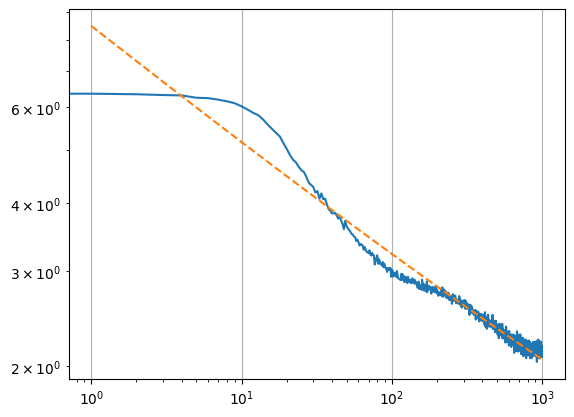

In [127]:
import numpy as np
from scipy.optimize import curve_fit

def power_law(x, a, b, c):
    return a * np.power(x, -b) + c

params, _ = curve_fit(power_law, xdata=np.arange(1, MAX_ITERS + 1), ydata=np.array(losses), p0=[5.0, 0.3, 1.7])
a, b, c = params
xi = np.arange(1, MAX_ITERS + 1)

plt.loglog(losses)
plt.loglog(xi, power_law(xi, a, b, c), linestyle='--')
plt.grid()
plt.show()

In [ ]:
from transformers import pipeline

pipeline = pipeline(task="text-generation", model="Qwen/Qwen2.5-1.5B")
pipeline("the secret to baking a really good cake is ")